# Linear Regression - Ridge Regression   
-------------------------

_Code by PJ Cabrera_  

## Project Guide  

--------------------
- [Project Overview](#overview)  
- [Data Review](#data)  
- [Coding Ridge Regression](#code)
- [Ridge Regression in `sklearn`](#sklearn)  

<a id = "overview"></a>
## Project Overview  
-------------

In coding Ridge Regression you will be asked to:  
- Mean center target variable and mean center / standardize observation  
- Calculate Ridge Regression weights using linear algebra
- Create a  hyperparameter tuning process   

**Motivation**: Ridge Regression offers a way to mitigate some of the weaknesses of Least Squares Linear Regression to build more robust models.  

**Problem**: Using housing data, we will attempt to predict house price using living area with a regression model.  

**Data**: Data comes from [Kaggle's House Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).  

See above link for Description of data.

<a id = "data"></a>  
### Data Exploration

Below provides a review of the "Housing" dataset.

In [10]:
### This cell imports the necessary modules and sets a few plotting parameters for display

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)  

### Read in the data
tr_path = './house-prices/train.csv'
test_path = './house-prices/test.csv'

data = pd.read_csv(tr_path)  

### The .head() function shows the first few lines of data for perspecitve
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


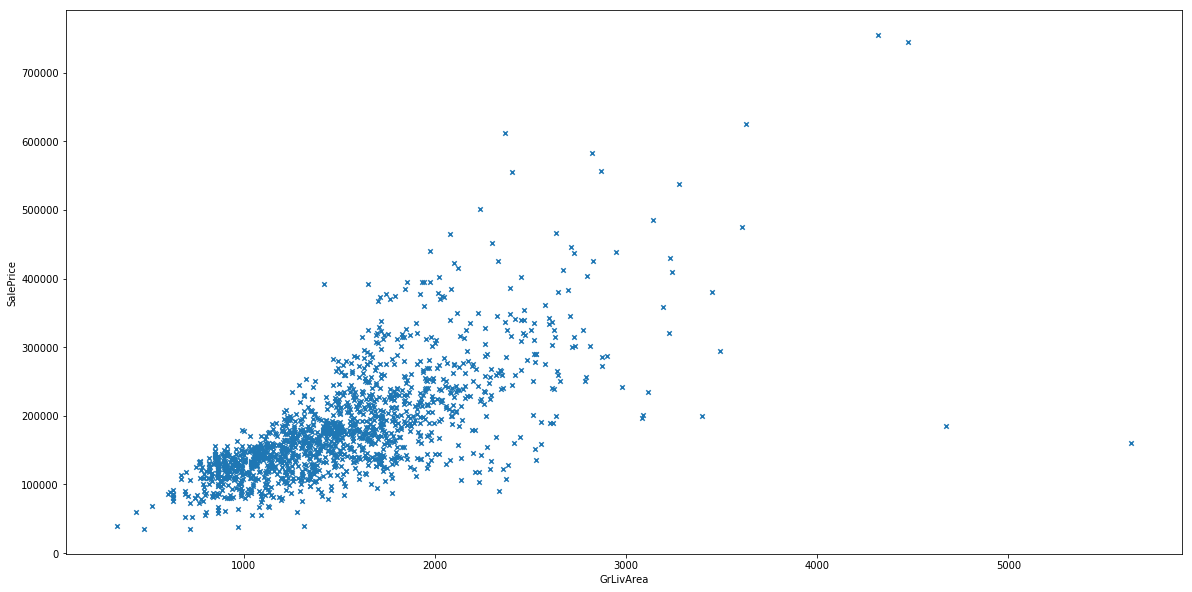

In [11]:
data.plot('GrLivArea', 'SalePrice', kind = 'scatter', marker = 'x');

<a id = "code"></a>
### Coding Ridge Regression   

#### Preprocessing
Before implementing Ridge Regression, it is important to mean-center our target variable and mean-center and standardize observations. I do this according to the following equations:  
#### Mean Center Target
$$y_{cent} = y_0 - \bar{y}$$

#### Standardize Observations
$$X_{std} = \frac{X_0-\bar{X}}{s_{X}}$$

Where $\bar{X}$ is the sample mean of X and $s_{X}$ is the sample standard deviation of X  


In [12]:

def standardize( num_list):
    """
    Standardize the given list of numbers
    
    Positional arguments:
        num_list -- a list of numbers
    
    Example:
        num_list = [1,2,3,3,4,4,5,5,5,5,5]
        nl_std = standardize(num_list)
        print(np.round(nl_std,2))
        #--> np.array([-2.11, -1.36, -0.61, -0.61,  
                0.14,  0.14,  0.88,  0.88,  0.88,
                0.88,  0.88])
    """
    
    return (num_list - np.mean(num_list)) / np.std(num_list)

Below I create a function which will preprocess  our data by performing:
* mean subtraction from $y$,
* dimension standardization for $x$.

Both according to the equations set out below.

#### Mean Center Target
$$y_{cent} = y_0 - \bar{y}$$

#### Standardize Observations
$$X_{std} = \frac{X_0-\bar{X}}{s_{X}}$$


In [13]:
def preprocess_for_regularization(data, y_column_name, x_column_names):
    """
    Perform mean subtraction and dimension standardization on data
        
    Positional argument:
        data -- a pandas dataframe of the data to pre-process
        y_column_name -- the name (string) of the column that contains
            the target of the training data.
        x_column_names -- a *list* of the names of columns that contain the
            observations to be standardized
        
    Returns:
        Return a DataFrame consisting only of the columns included
        in `y_column_name` and `x_column_names`.
        Where the y_column has been mean-centered, and the
        x_columns have been mean-centered/standardized.
        
        
    Example:
        data = pd.read_csv(tr_path).head()
        prepro_data = preprocess_for_regularization(data,'SalePrice', ['GrLivArea','YearBuilt'])
        
        print(prepro_data) #-->
                   GrLivArea  YearBuilt  SalePrice
                0  -0.082772   0.716753     7800.0
                1  -1.590161  -0.089594   -19200.0
                2   0.172946   0.657024    22800.0
                3  -0.059219  -1.911342   -60700.0
                4   1.559205   0.627159    49300.0
    """
    
    y = data[y_column_name]
    x = data[x_column_names]
    
    y_preprocessed = y - np.mean(y)
    x_standardized = standardize(x)

    dict = {y_column_name: y_preprocessed}
    for column in x_column_names:
        dict[column] = x_standardized[column]
    return pd.DataFrame(dict)

Next, I will implement the equation for ridge regression using the closed form equation:  

$$w_{RR}=(\lambda+X^TX)^{-1}X^Ty$$  

This function is very similar to the function used for Least Squares Regression, with a slightly different matrix to invert.  

The main change from Least Squares Regression is that $\lambda$ is a parameter *we* must set. This is different from the $w$ parameters that we calculate from either closed form or approximation algorithms.  

I will address tuning parameters such as $\lambda$ in the next section.  


In [14]:

def ridge_regression_weights(input_x, target_y, lambda_param):
    """Calculate ridge regression least squares weights.
    
    Positional arguments:
        input_x -- 2-d matrix of input data
        output_y -- 1-d numpy array of target values
        lambda_param -- lambda parameter that controls how heavily
            to penalize large weight values
        
    Example:
        training_y = np.array([208500, 181500, 223500, 
                                140000, 250000, 143000, 
                                307000, 200000, 129900, 
                                118000])
                                
        training_x = np.array([[1710, 1262, 1786, 
                                1717, 2198, 1362, 
                                1694, 2090, 1774, 
                                1077], 
                               [2003, 1976, 2001, 
                                1915, 2000, 1993, 
                                2004, 1973, 1931, 
                                1939]])
        lambda_param = 10
        
        rrw = ridge_regression_weights(training_x, training_y, lambda_param)
        
        print(rrw) #--> np.array([-576.67947107,   77.45913349,   31.50189177])
        print(rrw[2]) #--> 31.50189177
        
    Assumptions:
        -- output_y is a vector whose length is the same as the
        number of observations in input_x
        -- lambda_param has a value greater than 0
    """
    
    # step 1: transpose input_x or target_y if necessary
    n = input_x.shape[0]
    p = input_x.shape[1]
    y_dimension = target_y.shape[0]
 
    if y_dimension > 1:
        y = target_y
    else:
        y = target_y.transpose()
        y_dimension = y.shape[0]
  
    if n == y_dimension:
        X = input_x
    else:
        X = input_x.transpose()

    # step 2: prepend n-by-1 column of ones to X
    oneses = np.ones(shape=y.shape)[..., None]
    X = np.concatenate((oneses, X), 1)

    # step 3: calculate weights
    lambda_i = lambda_param * np.identity(X.shape[1])
    weights = np.linalg.inv(X.transpose().dot(X) + lambda_i).dot(X.transpose()).dot(y)
    return weights

training_y = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])
training_x = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077], 
                       [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]])
lambda_param = 10

rrw = ridge_regression_weights(training_x, training_y, lambda_param)

print(rrw) #--> np.array([-576.67947107,   77.45913349,   31.50189177])
print(rrw[2]) #--> 31.50189177

[-576.67947106   77.45913349   31.50189177]
31.501891773638206


#### Selecting the $\lambda$ parameter

For our final function before looking at the `sklearn` implementation of ridge regression, I create a hyper-parameter tuning algorithm.  

In ridge regression, we must pick a value for $\lambda$. We have some intuition about $\lambda$ from the equations that define it: small values tend to emulate the results from Least Squares, while large values will reduce the dimensionality of the problem. But the choice of $\lambda$ can be motivated with a more precise quantitative treatment.

Eventually, we will look to choose the value of $\lambda$ that minimizes validation error, which we will determine using $k$-fold cross-validation.

For this example here, we will solve a simpler problem: Find a value that minimizes the mean of the list returned by a function.

In [15]:
### Example of hiden function below:

### `hidden` takes a single number as a parameter (int or float) and returns a list of 1000 numbers
### the input must be between 0 and 50 exclusive

def hidden(hp):
    if (hp<=0) or (hp >= 50):
        print("input out of bounds")
    
    nums = np.logspace(0,5,num = 1000)
    vals = nums** 43.123985172351235134687934
    
    user_vals = nums** hp
    
    return vals-user_vals

Run the above cell and test out the functionality of `hidden`. Remember it takes a single number, between 0 and 50, as an argument


In [16]:

def minimize( passed_func ):
    """
    Find the numeric value that makes the mean of the
    output array returned from 'passed_func' as close to 0 as possible.
    
    Positional Argument:
        passed_func -- a function that takes a single number (between 0 and 50 exclusive)
            as input, and returns a list of 1000 floats.
        
    Example:
        passed_func = hidden
        min_hidden = minimize(passed_func)
        print(round(min_hidden,4))
        #--> 43.1204 (answers will vary, must be close to 43.123985172351)
    
    """
    last_result = 0
    minimized_x = 50
    while minimized_x:
        minimized_x = minimized_x - 0.0001
        last_result = np.mean(passed_func(minimized_x))
        if last_result > 0:
            break
    return minimized_x

passed_func = hidden
min_hidden = minimize(passed_func)
print(round(min_hidden,4))

43.1239


The above simulates hyper parameter tuning.  

In the case of ridge regression, you would be searching lambda parameters to minimize validation error.  

The `hidden` function would be analogous to the model building; the returned list analogous to residuals; and the mean of that list analogous to validation error.  

See below for an example of using the functions built above that automatically performs hyper-parameter tuning using mean-absolute-deviation.

In [17]:
def lambda_search_func(lambda_param):
    
    # Define X and y
    # with preprocessing
    df = preprocess_for_regularization(data.head(50),'SalePrice', ['GrLivArea','YearBuilt'])
    
    y_true = df['SalePrice'].values
    X = df[['GrLivArea','YearBuilt']].values
    
    # Calculate Weights then use for predictions
    weights = ridge_regression_weights(X, y_true, lambda_param )
    y_pred = weights[0] + np.matmul(X,weights[1:])
    
    # Calculate Residuals
    resid = y_true - y_pred
    
    # take absolute value to tune on mean-absolute-deviation
    # Alternatively, could use:
    # return resid **2-S
    # for tuning on mean-squared-error
    
    return abs(resid)

minimize(lambda_search_func)    # --> about 1.4957957957957957

49.9999

Implementing a k-folds cross-validation strategy will come in later assignments.


<a id = "sklearn"></a>

### Ridge Regression in `sklearn`  

Below gives the syntax for implementing ridge regression in sklearn.

In [18]:
from sklearn.linear_model import Ridge, LinearRegression

### Note, the "alpha" parameter defines regularization strength.
### Lambda is a reserved word in `Python` -- Thus "alpha" instead

### An alpha of 0 is equivalent to least-squares regression
lr = LinearRegression()
reg = Ridge(alpha = 100000)
reg0 = Ridge(alpha = 0)

# Notice how the consistent sklearn syntax may be used to easily fit many kinds of models
for m, name in zip([lr, reg, reg0], ["LeastSquares","Ridge alpha = 100000","Ridge, alpha = 0"]):
    
    m.fit(data[['GrLivArea','YearBuilt']], data['SalePrice'])
    print(name, "Intercept:", m.intercept_, "Coefs:",m.coef_,"\n")

LeastSquares Intercept: -2024976.362585636 Coefs: [  95.16733349 1045.86241944] 

Ridge alpha = 100000 Intercept: -1876820.7548806793 Coefs: [ 96.01060155 970.05661101] 

Ridge, alpha = 0 Intercept: -2024976.3625856352 Coefs: [  95.16733349 1045.86241944] 



Note, in the above example, an alpha of 100,000 is set for the ridge regularization. The reason an alpha value this high is required is because standardization / mean centering of our inputs did not occur, and instead of working with inputs on the order of [-4,4] we are on the interval of [0,2000].  
